## Use Custom Dataloading.py

In [5]:
from vae_scott import ResNetVAE
from custom_dataloading import encode_dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
vae = ResNetVAE(latent_dim=7, spatial=True).to(device)
vae.load_state_dict(torch.load('models/spatial_ae_7.pth', map_location=device))
vae.eval()

ResNetVAE(
  (encoder): ResNetVAEEncoderSpatial(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (levels): ModuleList(
      (0): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 

In [3]:
# load original dataset
train_transforms = torchvision.transforms.Compose([ToTensor()])

train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")



batch_size = 128   # could make this bigger; note for MNIST on Colab we're disk-speed limited, not GPU-limited
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)

Data set lengths: train: 60000, test: 10000


In [4]:
encode_dataset(vae, train_dl, test_dl, suffix='sp7')

[encode] train -> data/ResNetVAEEncoderSpatial_sp7/MNIST/train | N=60000, latent=1x7x7, dtype=<class 'numpy.float32'>


Encoding train: 100%|██████████| 469/469 [00:03<00:00, 133.27it/s]


[encode] test -> data/ResNetVAEEncoderSpatial_sp7/MNIST/test | N=10000, latent=1x7x7, dtype=<class 'numpy.float32'>


Encoding test: 100%|██████████| 79/79 [00:01<00:00, 55.75it/s]


### Code for above func before it became .py file

In [131]:
# from vae_scott import ResidualBlock, ResNetVAEEncoder, ResNetVAEDecoder, ResNetVAEEncoderSpatial, ResNetVAEDecoderSpatial, ResNetVAE
from vae_scott import ResNetVAE, test_inference, test_inference_spatial, log_example_images
import wandb

import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, RandomAffine, RandomErasing
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
import numpy as np
import os
from numpy.lib.format import open_memmap

In [129]:
class EncodedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, split="train", add_channel=True, mmap=True):
        """
        General dataset loader for encoded .npy latent datasets.

        Args:
            dataset_path (str): Path to dataset folder, e.g. '../data/ResNetVAEEncoderSpatial/MNIST'
            split (str): 'train' or 'test'
            add_channel (bool): Whether to add a channel dim (for (7,7) → (1,7,7))
            mmap (bool): Whether to memory-map large files instead of loading into RAM

        Path Structure
        <encoder_name>/
         └── <dataset_name>/
              ├── train/
              │    ├── data.npy
              │    └── target.npy
              └── test/
                   ├── data.npy
                   └── target.npy
        """
        self.dataset_path = dataset_path
        self.split = split
        self.add_channel = add_channel

        # Expected structure: <dataset_path>/<split>/data.npy + target.npy
        base = os.path.join(dataset_path, split)
        self.data_path = os.path.join(base, "data.npy")
        self.target_path = os.path.join(base, "target.npy")

        if not os.path.exists(self.data_path) or not os.path.exists(self.target_path):
            raise FileNotFoundError(f"Expected data.npy and target.npy in: {base}")

        mmap_mode = "r" if mmap else None
        self.data = np.load(self.data_path, mmap_mode=mmap_mode)
        self.targets = np.load(self.target_path, mmap_mode=mmap_mode)

        assert len(self.data) == len(self.targets), "Data and targets must be same length"

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.add_channel and x.ndim == 2:
            x = np.expand_dims(x, 0)  # (1, H, W)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.long)
        return x, y

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
ae_spatial_49 = ResNetVAE(latent_dim=49).to(device)
ae_spatial_49.load_state_dict(torch.load('models/spatial_ae_49.pth', map_location=device))
ae_spatial_49.eval()

ResNetVAE(
  (encoder): ResNetVAEEncoderSpatial(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (levels): ModuleList(
      (0): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ModuleList(
        (0-3): 4 x ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 

In [116]:
train_transforms = torchvision.transforms.Compose([
    ToTensor(),
    # uncomment next lines for extra augmentations
    #RandomAffine(degrees=15, translate=(0.1, 0.1)),
    #RandomErasing(p=0.2, scale=(0.02, 0.1))
])

train_ds = MNIST(root='./data', train=True,  download=True, transform=train_transforms)
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")



batch_size = 128   # could make this bigger; note for MNIST on Colab we're disk-speed limited, not GPU-limited
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=2, shuffle=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=2, shuffle=False, persistent_workers=True)

Data set lengths: train: 60000, test: 10000


In [132]:
@torch.no_grad()
def get_latent_dtype_dim(encoder, loader):
    encoder.eval()  # Safety eval

    x, _ = next(iter(loader))
    x = x.to(device, dtype=torch.float32)
    mu, _ = encoder(x)
    return mu.dtype, tuple(mu.squeeze(1).shape[1:])

@torch.no_grad()
def encode_dataset(model, train_dataloader, test_dataloader, dir_='data/'):
    # Some cheap checks
    assert hasattr(model, "encoder"), "Model must have an encoder attribute"
    assert model.encoder is not None, "Model encoder cannot be None"

    encoder = model.encoder
    encoder.eval()

    model_dir = model.encoder.__class__.__name__

    for loader, mode in [(train_dataloader, 'train'), (test_dataloader, 'test')]:
        print(f"Processing {mode} split...\n")
        dataset_dir = loader.dataset.__class__.__name__
        base_dir = os.path.join(dir_, model_dir, dataset_dir, mode)
        os.makedirs(base_dir, exist_ok=True)

        batches = len(loader)
        batch = i = 0
        pbar = tqdm(loader, desc=f"Loader: {dataset_dir} {mode}", total=batches)

        latent_torch_dtype, latent_img_dim = get_latent_dtype_dim(encoder, loader)
        latent_torch_dtype = str(latent_torch_dtype).replace("torch.", "")
        dtype_target = str(loader.dataset.targets.dtype).replace("torch.", "")
        N = loader.dataset.data.shape[0]

        data_mm   = open_memmap(os.path.join(base_dir, "data.npy"),   mode="w+", dtype=latent_torch_dtype, shape=(N, *latent_img_dim))
        target_mm = open_memmap(os.path.join(base_dir, "target.npy"), mode="w+", dtype=dtype_target, shape=(N,))

        for batch_idx, (data, target) in enumerate(pbar):
            data = data.to(device)

            mu, _ = encoder(data)
            mu = mu.squeeze(1)

            b = mu.size(0)  # latent_batch_size
            data_mm[i:i+b] = mu.detach().cpu().numpy()
            target_mm[i:i+b] = target.detach().cpu().numpy()
            i += b

            batch += 1
            pbar.set_description(f'Loader: {dataset_dir} {mode} Batch {batch_idx+1}/{batches}')  # Update pbar

        # Finish write
        data_mm.flush()
        target_mm.flush()
        pbar.close()

In [133]:
encode_dataset(ae_spatial_49, train_dl, test_dl)

Processing train split...



Loader: MNIST train Batch 469/469: 100%|██████████| 469/469 [00:03<00:00, 124.91it/s]


Processing test split...



Loader: MNIST test Batch 79/79: 100%|██████████| 79/79 [00:00<00:00, 121.91it/s]


In [134]:
root = "data/ResNetVAEEncoderSpatial/MNIST"

train_ds = EncodedDataset(root, split="train")
test_ds  = EncodedDataset(root, split="test")

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

2


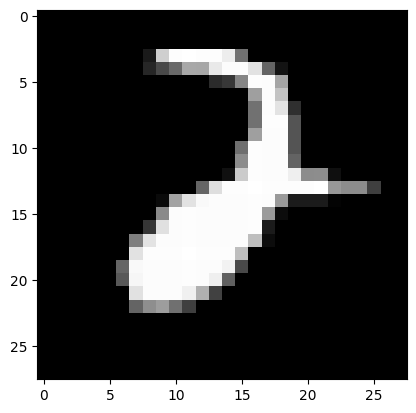

In [27]:
from matplotlib import pyplot as plt
img = x_batch[0].squeeze()
print(y_batch[0].item())
plt.imshow(img, cmap='gray')